In [1]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpg98j2fa8".


In [ ]:
%%writefile raytracing.cu
#include <iostream>
#include <cuda_runtime.h>
#include <cfloat>
#include <cmath>

#define checkCudaErrors(val) check_cuda( (val), #val, __FILE__, __LINE__ )
void check_cuda(cudaError_t result, char const *const func, const char *const file, int const line) {
    if (result != cudaSuccess) {
        std::cerr << "CUDA error = " << static_cast<unsigned int>(result) << " at " <<
            file << ":" << line << " '" << func << "' \n";
        std::cerr << "Error message: " << cudaGetErrorString(result) << std::endl;
        cudaDeviceReset();
        exit(99);
    }
}

class vec3 {
public:
    __host__ __device__ vec3() : e{0,0,0} {}
    __host__ __device__ vec3(float e0, float e1, float e2) : e{e0, e1, e2} {}

    __host__ __device__ float x() const { return e[0]; }
    __host__ __device__ float y() const { return e[1]; }
    __host__ __device__ float z() const { return e[2]; }

    __host__ __device__ vec3 operator+(const vec3 &v) const {
        return vec3(e[0]+v.e[0], e[1]+v.e[1], e[2]+v.e[2]);
    }
    __host__ __device__ vec3 operator-(const vec3 &v) const {
        return vec3(e[0]-v.e[0], e[1]-v.e[1], e[2]-v.e[2]);
    }
    __host__ __device__ vec3 operator*(float t) const {
        return vec3(t*e[0], t*e[1], t*e[2]);
    }
    __host__ __device__ vec3 operator/(float t) const {
        return *this * (1.0f/t);
    }

    __host__ __device__ float length() const {
        return sqrtf(e[0]*e[0] + e[1]*e[1] + e[2]*e[2]);
    }

    __host__ __device__ vec3 unit_vector() const {
        return *this / length();
    }

    float e[3];
};

__host__ __device__ inline vec3 operator*(float t, const vec3 &v) {
    return v * t;
}

__host__ __device__ inline float dot(const vec3 &u, const vec3 &v) {
    return u.e[0]*v.e[0] + u.e[1]*v.e[1] + u.e[2]*v.e[2];
}

// Луч (ray)
class ray {
public:
    __host__ __device__ ray() {}
    __host__ __device__ ray(const vec3& origin, const vec3& direction)
        : orig(origin), dir(direction) {}

    __host__ __device__ vec3 origin() const { return orig; }
    __host__ __device__ vec3 direction() const { return dir; }
    __host__ __device__ vec3 at(float t) const {
        return orig + t*dir;
    }

    vec3 orig;
    vec3 dir;
};

// Функция пересечения луча с сферой
__device__ bool hit_sphere(const vec3& center, float radius, const ray& r, float t_min, float t_max, float& t_hit) {
    vec3 oc = r.origin() - center;
    float a = dot(r.direction(), r.direction());
    float b = dot(oc, r.direction());
    float c = dot(oc, oc) - radius*radius;
    float discriminant = b*b - a*c;
    if (discriminant > 0) {
        float sqrt_disc = sqrtf(discriminant);
        float temp = (-b - sqrt_disc) / a;
        if (temp < t_max && temp > t_min) {
            t_hit = temp;
            return true;
        }
        temp = (-b + sqrt_disc) / a;
        if (temp < t_max && temp > t_min) {
            t_hit = temp;
            return true;
        }
    }
    return false;
}

// Функция цвета с трассировкой жёлтой сферы
__device__ vec3 ray_color(const ray& r) {
    vec3 sphere_center(0.0f, 0.0f, -1.0f);
    float sphere_radius = 0.5f;
    float t_hit;

    if (hit_sphere(sphere_center, sphere_radius, r, 0.001f, FLT_MAX, t_hit)) {
        vec3 hit_point = r.at(t_hit);
        vec3 normal = (hit_point - sphere_center).unit_vector();
        // Простой ламберт: цвет зависит от нормали, жёлтый базовый цвет
        vec3 base_color(1.0f, 1.0f, 0.0f);
        float intensity = 0.5f * (normal.y() + 1.0f); // от 0 до 1 по y нормали
        return intensity * base_color;
    }

    // Градиент неба
    vec3 unit_direction = r.direction().unit_vector();
    float t = 0.5f*(unit_direction.y() + 1.0f);
    return (1.0f - t)*vec3(1.0f, 1.0f, 1.0f) + t*vec3(0.5f, 0.7f, 1.0f);
}

// Ядро CUDA для рендеринга
__global__ void render(vec3 *fb, int max_x, int max_y, vec3 lower_left_corner, vec3 horizontal, vec3 vertical, vec3 origin) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    int j = threadIdx.y + blockIdx.y * blockDim.y;
    if (i >= max_x || j >= max_y) return;
    int pixel_index = j*max_x + i;

    float u = float(i) / float(max_x);
    float v = float(j) / float(max_y);
    ray r(origin, lower_left_corner + u*horizontal + v*vertical - origin);
    fb[pixel_index] = ray_color(r);
}

int main() {
    const int nx = 1200;
    const int ny = 600;
    const int num_pixels = nx*ny;
    size_t fb_size = num_pixels * sizeof(vec3);

    vec3 *fb;
    checkCudaErrors(cudaMallocManaged((void**)&fb, fb_size));

    vec3 lower_left_corner(-2.0f, -1.0f, -1.0f);
    vec3 horizontal(4.0f, 0.0f, 0.0f);
    vec3 vertical(0.0f, 2.0f, 0.0f);
    vec3 origin(0.0f, 0.0f, 0.0f);

    int tx = 8;
    int ty = 8;
    dim3 blocks((nx + tx - 1)/tx, (ny + ty - 1)/ty);
    dim3 threads(tx, ty);

    render<<<blocks, threads>>>(fb, nx, ny, lower_left_corner, horizontal, vertical, origin);
    checkCudaErrors(cudaGetLastError());
    checkCudaErrors(cudaDeviceSynchronize());

    std::cout << "P3\n" << nx << " " << ny << "\n255\n";
    for (int j = ny-1; j >= 0; j--) {
        for (int i = 0; i < nx; i++) {
            int pixel_index = j*nx + i;
            int ir = static_cast<int>(255.99f * fb[pixel_index].x());
            int ig = static_cast<int>(255.99f * fb[pixel_index].y());
            int ib = static_cast<int>(255.99f * fb[pixel_index].z());
            std::cout << ir << " " << ig << " " << ib << "\n";
        }
    }

    checkCudaErrors(cudaFree(fb));
    return 0;
}


Overwriting raytracing.cu


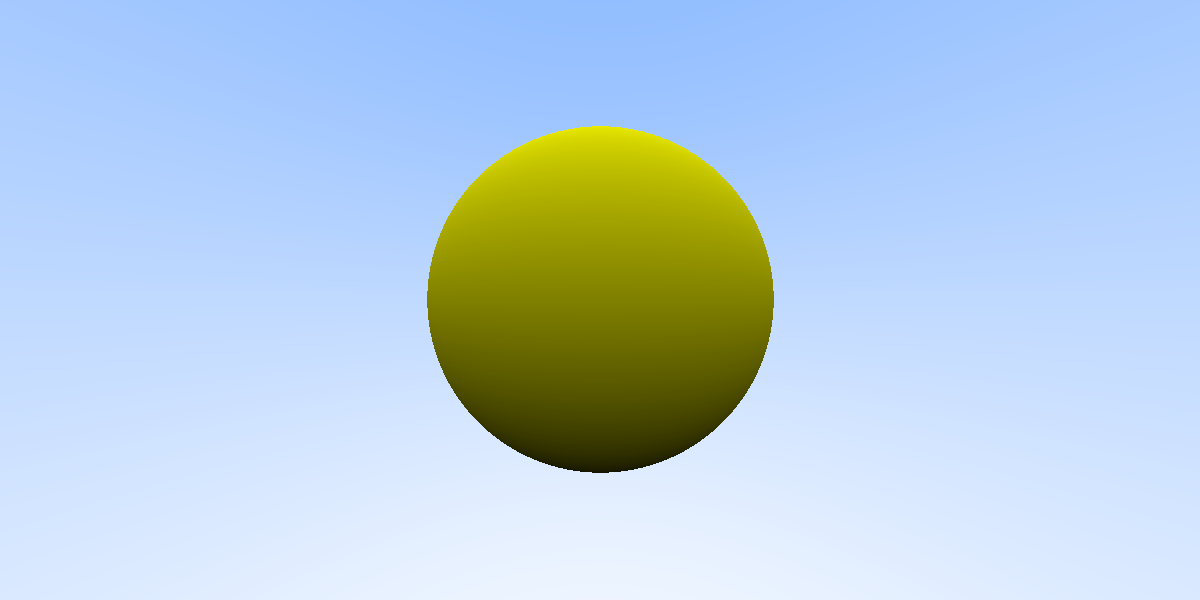

In [ ]:
!nvcc -arch=sm_75 -o raytracing raytracing.cu  # sm_37 для K80, sm_80 для A100[4][5]
!./raytracing > output.ppm
from PIL import Image
import numpy as np

with open('output.ppm') as f:
    data = np.loadtxt(f, skiprows=3, dtype=np.uint8).reshape(600,1200,3)

Image.fromarray(data, 'RGB')
